## Autoencoder VAE Versión 2.

Al comprimir el espacio de expresión génica en un espacio de dimensión inferior, el VAE, idealmente, aprendería principios biológicos, como las activaciones de la vía del cáncer, que ayudan a explicar cómo los tumores son similares y diferentes. El VAE también es un modelo generativo con un espacio latente que se puede interpolar para observar transiciones entre estados de cáncer.

Esta versión incluye numerosas variaciones si lo comparamos con el autoencoder que realicé para la obtención de valores manuscritos. 
Utiliza en el encoder:
- **batch_normalization:** han encontrado que se entrena más rápido y además con una activación de caraterísticas más heterogenea, batch_normalization añade una regulación de características escalando la activación a media=0 y varianza=1.Es como un método para normalizar los inputs de cada capa.
- **glorot uniform:** todos los pesos comienza inicializados a través de glorot uniform, de esta manera se pretende mantener la varianza similar a lo largo de todas las capas.
Funciones de pérdida:
- **Beta:** se incluye un parámetro beta que controla la contribución de la KL divergence en la VAE loss total conforme avanzan las epochs. Tras un estudio se demostró que kappa tiene un muy pequeña influencia en el entrenamiento, por tanto se usa k=1(kappa).
- **WarmUpCallBack:** una función para ver como como afecta las funciones de pérdida a la reconstrucción.
- **TQDM:** es una librería para estudiar el progreso de las barras durante el entrenamiento.

#### Datos
Tenemos características genómicas de mil tumores tomadas de 33 tipos diferentes de cáncer.
- **5000 Variables(features)->genes expresados-protein coding.**
- **10459 Observaciones -> gene expression para 10459 tumores (Escogidos entre los más irregulares y variables a través de la MAD).**

#### Entrenamiento
- Optimizador -> adam
- Encoding->rectified linear units and batch normalization.
- Decoding->sigmoid activation.


### Importaciones

Como importaciones tenemos las herramientas que necesitamos para crear las redes neuronales y llevar a cabo la experimentación.

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from keras import backend as K
from keras.layers import (Input, InputLayer, Dense, Lambda, Layer, Add, Multiply, Activation)
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras.callbacks import Callback
from keras import metrics,optimizers
import seaborn as sns
import keras

import pandas as pd
from matplotlib.ticker import FormatStrFormatter
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.layers.normalization import BatchNormalization
from keras_tqdm import TQDMNotebookCallback
from IPython.display import SVG

### Versiones

In [2]:
print(keras.__version__)
tf.__version__

2.2.4


'1.13.0-rc2'

### Cargamos los datos

Como hemos comentado tenemos observaciones con los genes mayormente expresados(5000) de 10459 tumores.

In [3]:
#rnaseq_file = os.path.join('data', 'pancan_scaled_zeroone_rnaseq.tsv')
rnaseq_df = pd.read_csv('pancan_scaled_zeroone_rnaseq.tsv.gz',sep='\t', index_col=0)

In [4]:
print(rnaseq_df.shape)
rnaseq_df.head(5)

(10459, 5000)


,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
TCGA-02-0047-01,0.678296,0.289910,0.034230,0.0,0.000000,0.084731,0.031863,0.037709,0.746797,0.687833,...,0.440610,0.428782,0.732819,0.634340,0.580662,0.294313,0.458134,0.478219,0.168263,0.638497
TCGA-02-0055-01,0.200633,0.654917,0.181993,0.0,0.000000,0.100606,0.050011,0.092586,0.103725,0.140642,...,0.620658,0.363207,0.592269,0.602755,0.610192,0.374569,0.722420,0.271356,0.160465,0.602560
TCGA-02-2483-01,0.785980,0.140842,0.081082,0.0,0.000000,0.000000,0.000000,0.000000,0.730648,0.657189,...,0.437658,0.471489,0.868774,0.471141,0.487212,0.385521,0.466642,0.784059,0.160797,0.557074
TCGA-02-2485-01,0.720258,0.122554,0.180042,0.0,0.000000,0.000000,0.000000,0.000000,0.720306,0.719855,...,0.553306,0.373344,0.818608,0.691962,0.635023,0.430647,0.453690,0.364494,0.161363,0.607895
TCGA-02-2486-01,0.767127,0.210393,0.034017,0.0,0.061161,0.000000,0.053021,0.000000,0.739546,0.665684,...,0.601268,0.379943,0.506839,0.684320,0.607821,0.320113,0.476190,0.122722,0.389544,0.698548


Separamos en train y en test

In [5]:
test_set_percent = 0.1
rnaseq_test_df = rnaseq_df.sample(frac=test_set_percent)
rnaseq_train_df = rnaseq_df.drop(rnaseq_test_df.index)

In [6]:
gene_expression=rnaseq_df.columns.tolist()

### Variables e hiperparámetros

In [7]:
original_dim=rnaseq_df.shape[1]
latent_dim = 100

batch_size=50
epochs = 50
learning_rate=0.0005

beta = K.variable(0)
kappa = 1
epsilon_std = 1.0

Instructions for updating:
Colocations handled automatically by placer.


### Encoder

Incluyendo **batch_normalization** han encontrado que se entrena más rápido y además con una activación de caraterísticas más heterogenea, batch_normalization añade una regulación de características escalando la activación a media=0 y varianza=1.Es como un método para normalizar los inputs de cada capa. 

In [12]:
##Creamos la capa de entrada
inputs = Input(shape=(original_dim,),name='encoder_input')
##Creamos capa intermedia
x_encoder = Dense(latent_dim,kernel_initializer='glorot_uniform')(inputs)
##Creamos dos capas de salida,media y log_desviacion(se usa en lugar de la estándar)
z_mean_dense_batchnorm = BatchNormalization()(x_encoder)
log_desviacion_dense_batchnorm = BatchNormalization()(x_encoder)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)
log_desviacion = Activation('relu')(log_desviacion_dense_batchnorm)

### Decoder

In [13]:
##Creamos capa de entrada del decodificador
latent_vector = Input(shape=(latent_dim,), name='latent_vector')
outputs = Dense(original_dim,kernel_initializer='glorot_uniform',activation='sigmoid')(latent_vector)

### Sampler y CustomVariationalLayer

La función sampler es el generador del vector z y la función CustomVariationalLayer aprende y actúa sobre el entrenamiento. Se encuentra al final del modelo

In [14]:
def sampler(args):
    z_mean, z_log = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # mean and log of variance of Q(z|X)
    # we sample from the standard normal a matrix of batch_size * latent_size (taking into account minibatches)
    epsilon = K.random_normal(shape=(batch,dim))# by default, random_normal has mean=0 and std=1.0
    # sampling from Z~N(μ, σ^2) is the same as sampling from μ + σX, X~N(0,1)
    return z_mean + K.exp(0.5 * z_log) * epsilon

z = Lambda(sampler,output_shape=(latent_dim, ))([z_mean_encoded, log_desviacion])

class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    This function is borrowed from:
    https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + log_desviacion - K.square(z_mean_encoded) - 
                                K.exp(log_desviacion), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

### WarmUpCallBack

Callback es un set de funciones que permite estudiar el entrenamiento mientras éste está en curso. Puedes llamar una lista de callback en el método fit. Estos métodos seran llamados en cada etapa del entrenamiento.

In [15]:
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

### Compilación de modelos-VAE

El **CustomVariationalLayer()** incluye la función de pérdida VAE (reconstruction + (beta * KL)), que es lo que impulsará a nuestro modelo a aprender una representación interpretable del espacio de expresión génica.

El VAE compilado con un optimizador Adam y una función de pérdida personalizada incorporada. El parámetro loss_weights garantiza que la versión beta se actualice en cada devolución de llamada de final de época

In [16]:
##Instanciamos el optimizador
adam = optimizers.Adam(lr=learning_rate)

##Instanciamos el encoder
encoder = Model(inputs,[z_mean_encoded,log_desviacion,z],name='encoder')
print('Encoder\n')
encoder.summary()
##Instanciamos el decoder
decoder = Model(latent_vector,outputs,name='decoder')
print('Decoder\n')
decoder.summary()

outputs_final= decoder(encoder(inputs)[2])

##Creamos modelo final con la capa 'CustomVariationalLayer'
vae_layer = CustomVariationalLayer()([inputs, outputs_final])
vae = Model(inputs,vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])
print('VAE\n')
vae.summary()

Encoder

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 5000)         0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 100)          500100      encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 100)          400         dense_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 100)          400         dense_4[0][0]                    
___________________________________________________________________________________

### Visualización del modelo

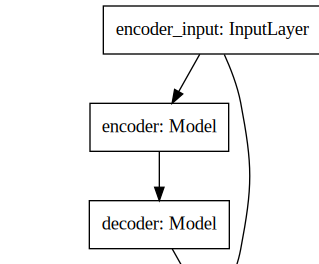

In [17]:
# Visualize the connections of the custom VAE model
plot_model(vae, to_file='modelo.png')
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))
SVG(model_to_dot(decoder).create(prog='dot', format='svg'))
SVG(model_to_dot(vae).create(prog='dot', format='svg'))

### Entrenamiento

In [18]:
%%time
hist = vae.fit(np.array(rnaseq_train_df),
               shuffle=True,
               epochs=epochs,
               verbose=0,
               batch_size=batch_size,
               validation_data=(np.array(rnaseq_test_df), None),
               callbacks=[WarmUpCallback(beta, kappa),
                          TQDMNotebookCallback(leave_inner=True, leave_outer=True)])

Instructions for updating:
Use tf.cast instead.



Wall time: 6min 17s


### Visualización del entrenamiento

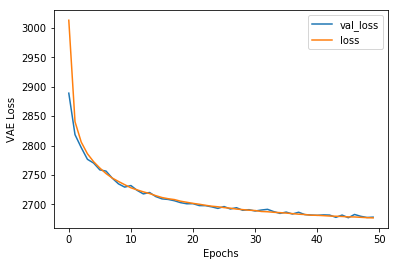

In [19]:
# Visualize training performance
history_df = pd.DataFrame(hist.history)
hist_plot_file = os.path.join('figures', 'onehidden_vae_training.pdf')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

### Estudio de modelos por separado

1.Respecto al encoder
- Poder ser utilizado para comprimir otros tumores

2.Respecto al decoder
- Modelo generativo

3.El espacio latente de todos los cánceres
- La representación reducida no linear de tumores puede ser usado como características para varias tareas.
  - Tareas de aprendizaje supervisado prediciendo inactivación de genes
  - Interpolar a través de este espacio para observar como la expresión génica cambia entre dos estados de cancer
  
4.Los pesos de los nodos para realizar la codificación
- Aprender diferencias biológicas según la activación de diferentes tumores.

### Observación de la activación de nodos

In [20]:
encoded_rnaseq_df,_,_ = encoder.predict_on_batch(rnaseq_df)
encoded_rnaseq_df = pd.DataFrame(encoded_rnaseq_df, index=rnaseq_df.index) ##Lo pasamos a dataframe para poder tratarlo

In [21]:
encoded_rnaseq_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
TCGA-02-0047-01,0.000000,1.816092,4.044361,0.145077,0.000000,6.106706,0.080684,0.000000,0.000000,0.000000,...,0.000000,0.180914,0.000000,0.133210,0.000000,0.000000,0.447283,0.000000,0.669333,0.000000
TCGA-02-0055-01,0.000000,5.942916,0.364176,0.000000,0.000000,5.537058,0.000000,0.000000,0.000000,0.080813,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.168227,0.921749,0.000000,0.000000,0.334925
TCGA-02-2483-01,0.000000,0.000000,0.124724,0.000000,0.000000,5.077076,0.000000,0.000000,0.000000,0.585016,...,0.000000,4.789838,0.000000,6.597468,0.000000,0.000000,2.134727,0.000000,0.000000,0.000000
TCGA-02-2485-01,0.481582,4.552354,3.809557,0.000000,2.508537,6.186780,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.677514,0.255064,0.049965,0.000000,0.000000,0.000000,0.000000,0.150729,0.000000
TCGA-02-2486-01,2.578734,9.853311,9.354247,1.361312,0.512573,5.838670,1.889889,0.000000,0.000000,0.000000,...,0.432554,1.049209,0.000000,0.000000,0.090571,0.145025,2.207272,0.000000,0.130302,1.018543
TCGA-04-1348-01,7.672048,0.213313,0.000000,11.299353,4.877659,0.000000,0.600834,1.077997,0.000000,5.561157,...,0.000000,0.000000,2.037721,1.944396,2.811864,2.056705,3.756991,0.000000,2.593285,2.725087
TCGA-04-1357-01,10.446991,0.000000,3.679590,4.787125,3.953828,0.000000,4.719891,0.342051,0.000000,1.145270,...,0.000000,1.625586,0.945755,1.144910,2.721298,0.000000,2.247263,0.203830,2.196875,5.717946
TCGA-04-1362-01,6.264437,0.000000,3.266966,9.428288,2.964624,0.000000,8.870564,0.122624,0.000000,8.249760,...,0.000000,0.920643,3.531740,0.228579,0.000000,0.000000,0.000000,0.000000,2.208181,0.000000
TCGA-04-1364-01,1.309366,0.000000,6.546947,12.901201,5.210964,0.000000,5.118565,0.000000,0.000000,7.487358,...,0.925897,5.928947,0.000000,1.533315,0.628259,0.000000,1.022210,0.000000,1.538149,0.613819
TCGA-04-1365-01,9.138672,0.000000,4.113050,5.382115,5.607386,0.000000,5.371694,0.000000,0.000000,3.850462,...,0.000000,0.000000,1.325288,0.981080,2.593027,0.000000,2.698748,0.000000,0.572851,1.696230


In [22]:
# What are the most and least activated nodes
sum_node_activity = encoded_rnaseq_df.sum(axis=0).sort_values(ascending=False)

# Top 10 most active nodes
print(sum_node_activity.head(10))

# Bottom 10 least active nodes
sum_node_activity.tail(10)

55    29147.353516
75    28624.193359
99    26892.585938
43    26407.187500
2     25810.656250
37    25758.771484
68    25416.310547
3     25105.988281
14    25026.802734
41    25024.167969
dtype: float32


79    13657.500977
88    13576.046875
11    13508.077148
16    13306.919922
8     13201.239258
76    13104.473633
22    12625.290039
42    12461.902344
18    12047.084961
5     11699.207031
dtype: float32

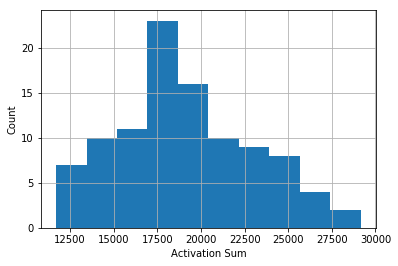

In [23]:
# Histogram of node activity for all 100 latent features
sum_node_activity.hist()
plt.xlabel('Activation Sum')
plt.ylabel('Count');

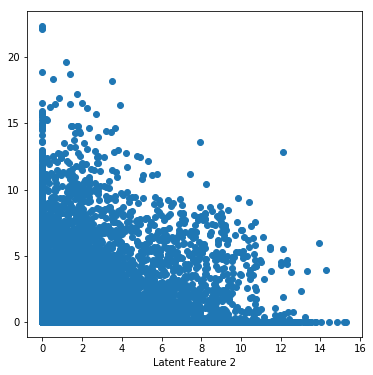

In [24]:
# Example of node activation distribution for the first two latent features
plt.figure(figsize=(6, 6))
plt.scatter(encoded_rnaseq_df.iloc[:, 1], encoded_rnaseq_df.iloc[:, 2])
plt.xlabel('Latent Feature 1')
plt.xlabel('Latent Feature 2');

In [25]:
# How well does the model reconstruct the input RNAseq data
encoder = Model(inputs, z_mean_encoded)
encoded_rnaseq_df = encoder.predict_on_batch(rnaseq_df)
input_rnaseq_reconstruct = decoder.predict(np.array(encoded_rnaseq_df))
input_rnaseq_reconstruct = pd.DataFrame(input_rnaseq_reconstruct, index=rnaseq_df.index,
                                        columns=rnaseq_df.columns)
input_rnaseq_reconstruct.head(2)

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
TCGA-02-0047-01,0.557508,0.247376,0.159108,0.04992,0.031480,0.044115,0.052392,0.041028,0.581893,0.541113,...,0.473779,0.531336,0.755476,0.661313,0.578651,0.342006,0.409828,0.478020,0.200584,0.607641
TCGA-02-0055-01,0.126272,0.600519,0.155052,0.09322,0.041506,0.071432,0.083192,0.068621,0.107471,0.081773,...,0.556409,0.543803,0.585221,0.586799,0.615972,0.379120,0.591493,0.175646,0.188333,0.570253


In [26]:
reconstruction_fidelity = rnaseq_df - input_rnaseq_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(rnaseq_df.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
gene_summary.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
PPAN-P2RY11,-0.003130,0.231174
GSTT1,0.007653,0.219294
GSTM1,-0.002493,0.217185
TBC1D3G,0.000988,0.192071
RPS28,0.020588,0.178488


C:\Users\angel\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


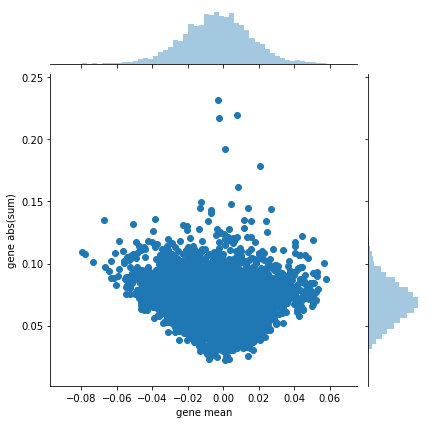

In [27]:
# Mean of gene reconstruction vs. absolute reconstructed difference per sample
g = sns.jointplot('gene mean', 'gene abs(sum)', data=gene_summary, stat_func=None);